**Recopiez ce notebook et envoyez-moi le lien à la fin de la séance.**

Votre **nom**: NGUYEN


Votre **prénom**: Tai

Votre **nombre etudiant**: 12108339


*Observations/commentaires éventuels de l'étudiant à l'enseignant*:



# MLP Neural Networks for 2d classification

This notebook will show you how to use **PyTorch** to build simple neural network.
We will use these networks to classify points from 2 classes in the plane (2 dimensions).


We start with a linear model, then a fully connected MLP with two hidden layers:
 * input retina with 2 neurons ($(x,y)$)
 * a linear layer + ReLu with N1 neurons
 * another one with N2 neurons
 * output layer, with one neuron per class.
 
As it is a classification problem, we will use the cross-entropy cost function (`CrossEntropyLoss`).

Please note that in order to keep the code simple, we use all the available data for training, and don't use any evaluation/test sets (this a _bad_ practice, but we're just playing here !).

*Emmanuel Viennet, 2019-12-15, 2021-01-03, 2022-01-11*

# Initialization and Helper functions

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
plt.rcParams["figure.figsize"] = (12, 8) # (w, h)
from collections import OrderedDict
import copy

import sklearn, sklearn.datasets # used to generate a dataset

import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
def plot_data(X, y, figsize=None, newfig=True):
    "A simple data plot"
    if newfig:
        plt.figure(figsize=figsize)
    plt.plot(X[y!=1, 0], X[y!=1, 1], 'or', alpha=0.9, label=0, markersize=8)
    plt.plot(X[y==1, 0], X[y==1, 1], 'ob', alpha=0.9, label=1, markersize=9)
    plt.xlim((min(X[:, 0])-0.1, max(X[:, 0])+0.1))
    plt.ylim((min(X[:, 1])-0.1, max(X[:, 1])+0.1))
    plt.legend()

def subplot_2d_model(ax, X, y, model, subtitle="", step=0.001):
    """Plot data and model output classes"""
    if subtitle:
        ax.set_title(subtitle)
    # use a mesh grid
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    # Generates a meshgrid and apply the model on each point of the grid
    xx, yy = np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))
    Xgrid = torch.Tensor(np.c_[xx.ravel(), yy.ravel()])
    Ygrid = model(Xgrid).detach().numpy()
    # The class is given by the max output
    Ygrid_class = np.argmax(Ygrid, axis=1).reshape(xx.shape)
    
    # Display points of the mesh
    plt.imshow(Ygrid_class, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Set3_r,
           aspect='auto', origin='lower')
    # Add the sample points (training set):
    plot_data(X, y, newfig=False)
    
def plot_2d_model(X, y, model, title="", step=0.001):
    """Display the sample and the classes computed by the NN model"""
    fig = plt.figure(figsize=(18, 16))
    ax = fig.add_subplot( 111 )
    subplot_2d_model(ax, X, y, model, step=step)
    plt.title(title)
    return plt

### Confusion Matrix (for classification)
The confusion matrix allows to count the distinct types of errors of a classifier.
The cell $(i, j)$ gives the number of examples from class $i$ classified by the model in class $j$.


In [3]:
def confusion_matrix( y, y_pred ):
    """Confusion matrix
    CM[b,c] = number of example from class b classified by the model in class c
    """
    # y et y_pred are vectors containing the index of classes (0, .., nbClass)
    NbClass = len(np.unique(y)) # number of classes
    CM = np.zeros((NbClass,NbClass))
    # The predicted class is given by the max of the output
    for i in range(len(x_data)):
        real_class = y[i]
        pred_class = np.argmax(y_pred[i])
        #print("real", real_class, "predicted", pred_class)
        CM[real_class, pred_class] += 1
    return CM

# Setup data

Number of examples 100
X.mean =  [0.51339765 0.49191772]
Number of classes: 2
min(y)= 0 max(y)= 1


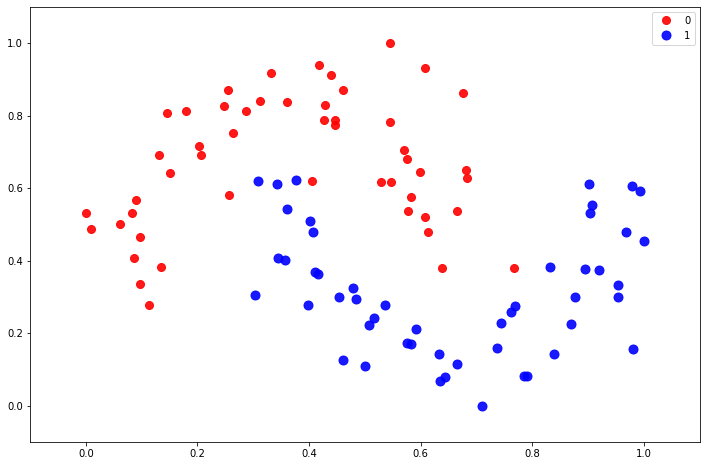

In [4]:
X, y = sklearn.datasets.make_moons(n_samples=100, shuffle=True, noise=0.2, random_state=0)
# X[:,0] = (X[:,0]+1)/3 - 0.5
X = (X - X.min(axis=0)) / (X.max(axis=0)-X.min(axis=0))
N = X.shape[0]
print("Number of examples", N)
print("X.mean = ", X.mean(axis=0))
NbClass = len(np.unique(y)) # number of distinct classes
print("Number of classes:", NbClass)
print("min(y)=", min(y), "max(y)=", max(y))

# Display data
plot_data(X,y, figsize=(12,8))

In [5]:
# Data formating
# from_numpy converts a Numpy array to a Tensor.
print("X.dtype=", X.dtype)
x_data = torch.Tensor(X)
y_data = torch.from_numpy(y)
# Have a look at the data types:
print("y.dtype=", y.dtype)
print("y_data.dtype=", y_data.dtype)
print("x_data.dtype=", x_data.dtype)

X.dtype= float64
y.dtype= int64
y_data.dtype= torch.int64
x_data.dtype= torch.float32


Note that PyTorch uses `float32` type for input tensors, in order to reduce memory footprint and accelerate computations.

# A Linear Model

This model is a neural network with one linear layer (`nn.Linear`) with `NbClass`output cells
(no hideen layers). Each output cell thus computes a dot product between the input and its weights.

The class is given by the most active output cell.

In PyTorch, you just need to define the `__init__` function which is bluilding the network (defining its architecture), and a `forward` function, which computes the output given the input. The gradients are automatically computed !

In [6]:
class LinearNNModel(nn.Module):
    def __init__(self):
        super(LinearNNModel, self).__init__()
        self.linear_layer = nn.Linear(2, NbClass)
    
    def forward(self, x):
        x = self.linear_layer(x)
        return x

model = LinearNNModel()

In [7]:
# The criteria to optmize (cost)
criterion = nn.CrossEntropyLoss()

PyTorch proposes several opmization algorithms. SGD is a good starting choice. We specify the learning rate (lr) and a momentum (an opmization trick stabilizing the convergence).


In [8]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

0.6767947673797607


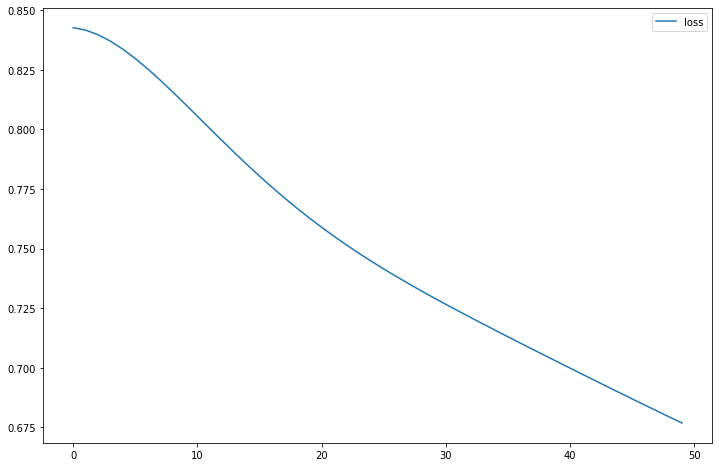

In [9]:
# Learning loop
batch_size = 100
num_epochs = 50

losses = []
for epoch in range(num_epochs):
    for beg_i in range(0, x_data.size(0), batch_size):
        x_batch = x_data[ beg_i:beg_i + batch_size, :]
        y_batch = y_data[ beg_i:beg_i + batch_size]
        # reset gradients to zero:
        optimizer.zero_grad()
        # forward:
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        # backpropagation
        loss.backward()
        optimizer.step()
        losses.append(loss.data.item())

plt.plot(losses, label="loss")
plt.legend()
print(losses[-1])

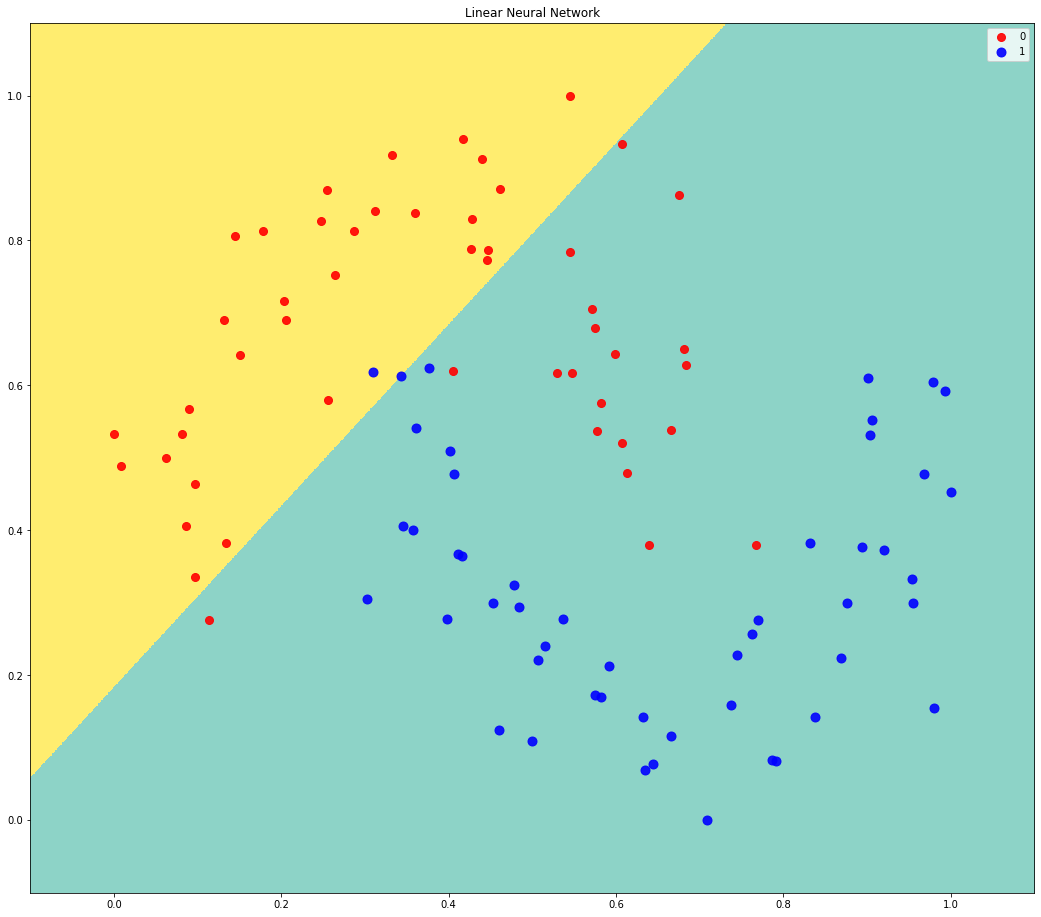

In [10]:
jnk=plot_2d_model(X, y, model, "Linear Neural Network")

In [11]:
# Computes network outputs and convert them back to a NumPy array
y_pred = model(x_data).detach().numpy()

CM = confusion_matrix(y, y_pred)
print(CM)

[[31. 19.]
 [ 1. 49.]]


# Questions:

Write simple code to answer the following questions:


- How many examples are missclassified ? 
- What is the error rate in percent ?


In [12]:
y_hat_class = [np.argmax(y_pred[i]) for i in range(len(y_pred))]
y_diff = np.where(y_hat_class != y)[0]
num_sample_miss = len(y_diff)
print(f"The number of samples misclassified: {num_sample_miss}")

The number of samples misclassified: 20


In [13]:
print(f'The error rate is: {100*(CM[0,1]/50. + CM[1,0]/50.)}')

The error rate is: 40.0


- What is the last measured value of the cost ? 
- Did the learning converged ? -> **The learning hasn't converged yet. Because the curve of losses value has a high slope.**
- Should we use more epochs ? -> **Yes we should train more epochs**

In [14]:
print(f"The last measured value of the cost function is: {losses[-1]}")

The last measured value of the cost function is: 0.6767947673797607


If we run more epochs, how evolves the cost ? Do the confusion matrix enhances ?
-> **Continue training with 100000 epochs, the model converged and the curve of losses value hasn't a slope**

100%|████████████████████████████████████████████████████| 100000/100000 [00:39<00:00, 2542.32it/s]


0.28876546025276184


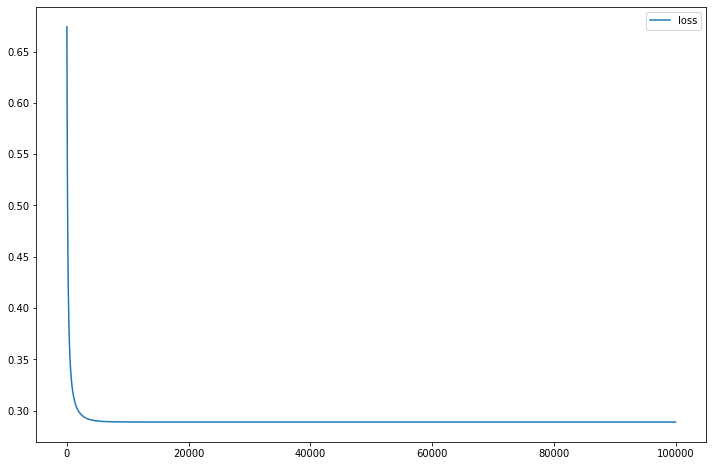

In [15]:
# Learning loop
from tqdm import tqdm
batch_size = 100
num_epochs_extra = 100000
losses = []
for epoch in tqdm(range(num_epochs_extra)):
    for beg_i in range(0, x_data.size(0), batch_size):
        x_batch = x_data[ beg_i:beg_i + batch_size, :]
        y_batch = y_data[ beg_i:beg_i + batch_size]
        # reset gradients to zero:
        optimizer.zero_grad()
        # forward:
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        # backpropagation
        loss.backward()
        optimizer.step()
        losses.append(loss.data.item())

plt.plot(losses, label="loss")
plt.legend()
print(losses[-1])

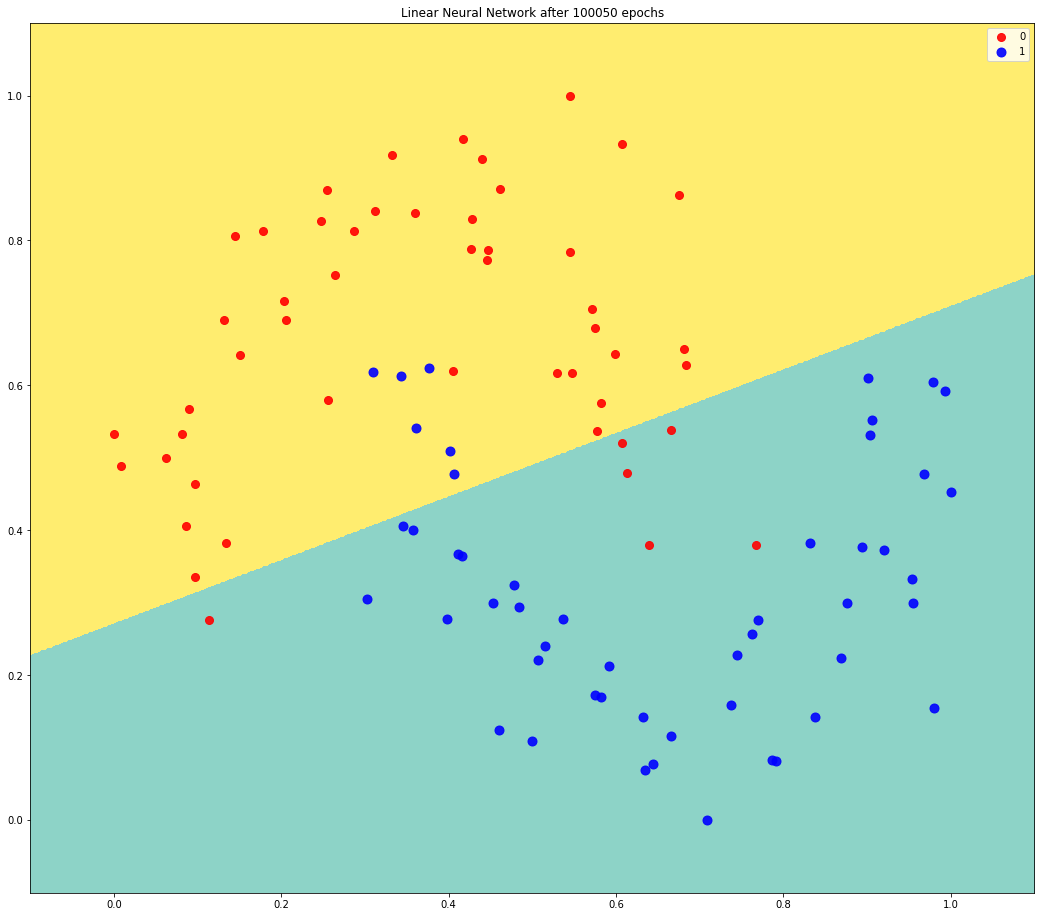

In [16]:
jnk=plot_2d_model(X, y, model, "Linear Neural Network after 100050 epochs")

In [17]:
## confusion matrix after 100050 epochs

y_pred = model(x_data).detach().numpy()

CM = confusion_matrix(y, y_pred)
print('Confusion matrix after 100050 epochs')
print(CM)

Confusion matrix after 100050 epochs
[[44.  6.]
 [ 6. 44.]]


## A fully connected neural network

Our second model is a neural network with three hidden layers, and ReLu activation functions.

The number of neurons per layer is:

`2 -> N1 -> N2 -> NbClass`

You can change `N1`, `N2` below.


The `__init__` constructor creates 3 fully connected linear layers (fc1, fc2, ..., "fc" meaning "fully connected", used by the `forward` method. 

In [18]:
# The Neural Network model:
class Net2(nn.Module):
    def __init__(self, N1=5, N2=5):
        "Build fully connected NN with 2 hidden layers"""
        super(Net2, self).__init__()
        self.N1, self.N2 = N1, N2
        self.fc1 = nn.Linear(2, N1)
        self.fc2 = nn.Linear(N1, N2)
        self.fc3 = nn.Linear(N2, NbClass)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [19]:
# Create network and optimizer:

torch.manual_seed(12345678) # for reproducibility
net = Net2(N1=5, N2=5)
# The criteria to optimize (cost function)
criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(net.parameters(), 0.008)

# Etonnants sauts !
# optimizer = torch.optim.SGD(net.parameters(), lr=0.05, momentum=0.3)

# Le meilleur trouvé:
optimizer = torch.optim.SGD(net.parameters(), lr=0.05, momentum=0.1)

#### Learning the Neural Network


0001	0.691026
0011	0.303859
0021	0.294253
0031	0.288343
0041	0.28486
0051	0.281245
0061	0.280003
0071	0.279463
0081	0.278268
0091	0.278864
0101	0.278051
0111	0.27802
0121	0.277625
0131	0.277242
0141	0.276647
0151	0.276564
0161	0.275922
0171	0.275733
0181	0.274749
0191	0.274404
0201	0.274887
0211	0.2742
0221	0.274436
0231	0.275031
0241	0.273599
0251	0.272221
0261	0.274631
0271	0.273751
0281	0.27313
0291	0.272554
0301	0.270896
0311	0.272138
0321	0.272916
0331	0.273884
0341	0.272077
0351	0.271176
0361	0.274
0371	0.271682
0381	0.271835
0391	0.270791
0401	0.271764
0411	0.266489
0421	0.270945
0431	0.268657
0441	0.271623
0451	0.271497
0461	0.264666
0471	0.26662
0481	0.262014
0491	0.264403
0501	0.26047
0511	0.259032
0521	0.271283
0531	0.266428
0541	0.263812
0551	0.268679
0561	0.266114
0571	0.262156
0581	0.268255
0591	0.266409
0601	0.262756
0611	0.263193
0621	0.266686
0631	0.260107
0641	0.261361
0651	0.264128
0661	0.265355
0671	0.263716
0681	0.26333
0691	0.256663
0701	0.256292
0711	0.237855
072

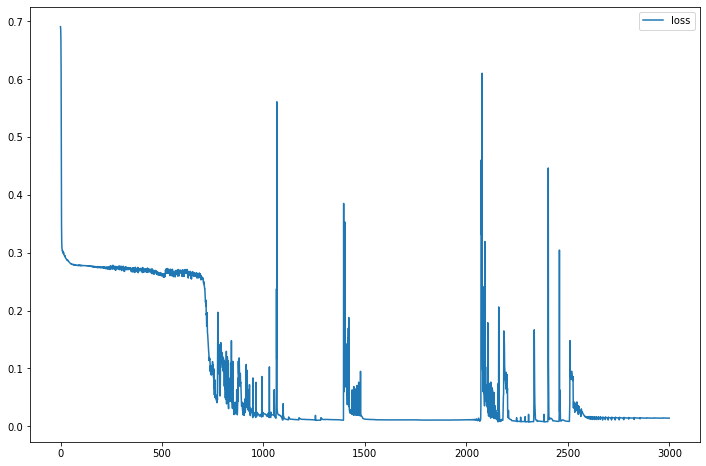

In [20]:
# Learning (without mini-batch)

min_nb_epochs = 100
max_nb_epochs = 3000

# Stop criteria: no average on window did not change more than min_change
window_size=10
min_change=1e-4

losses = []
models_states = OrderedDict()
for epoch in range(max_nb_epochs):
    for i in range(x_data.size(0)):
        x_i = x_data[ i:i + 1, :]
        y_i = y_data[ i:i + 1]
        # reset gradients to zero
        optimizer.zero_grad()
        # forward:
        outputs = net(x_i)
        loss = criterion(outputs, y_i)
        # backpropagation:
        loss.backward()
        optimizer.step()
    # After epoch, computes average loss on training set
    train_outputs = net(x_data)
    train_loss = criterion(train_outputs, y_data)
    losses.append(train_loss.data.item()) # record cost (loss) after each epoch
    models_states[len(losses)] = copy.deepcopy(net.state_dict())
    if len(losses) % window_size == 1:
        print("%04d\t%g" %(len(losses), losses[-1]) )
        
    # Should we stop ?
#     if len(losses) > min_nb_epochs:
#         last_avg_loss = np.mean(losses[-window_size:])
#         before_avg_loss = np.mean(losses[-2*window_size:-window_size])
#         if abs(last_avg_loss-before_avg_loss) < min_change:
#             print("no more changes: stopping !")
#             break

plt.plot(losses, label="loss")
plt.legend()
print(losses[-1])




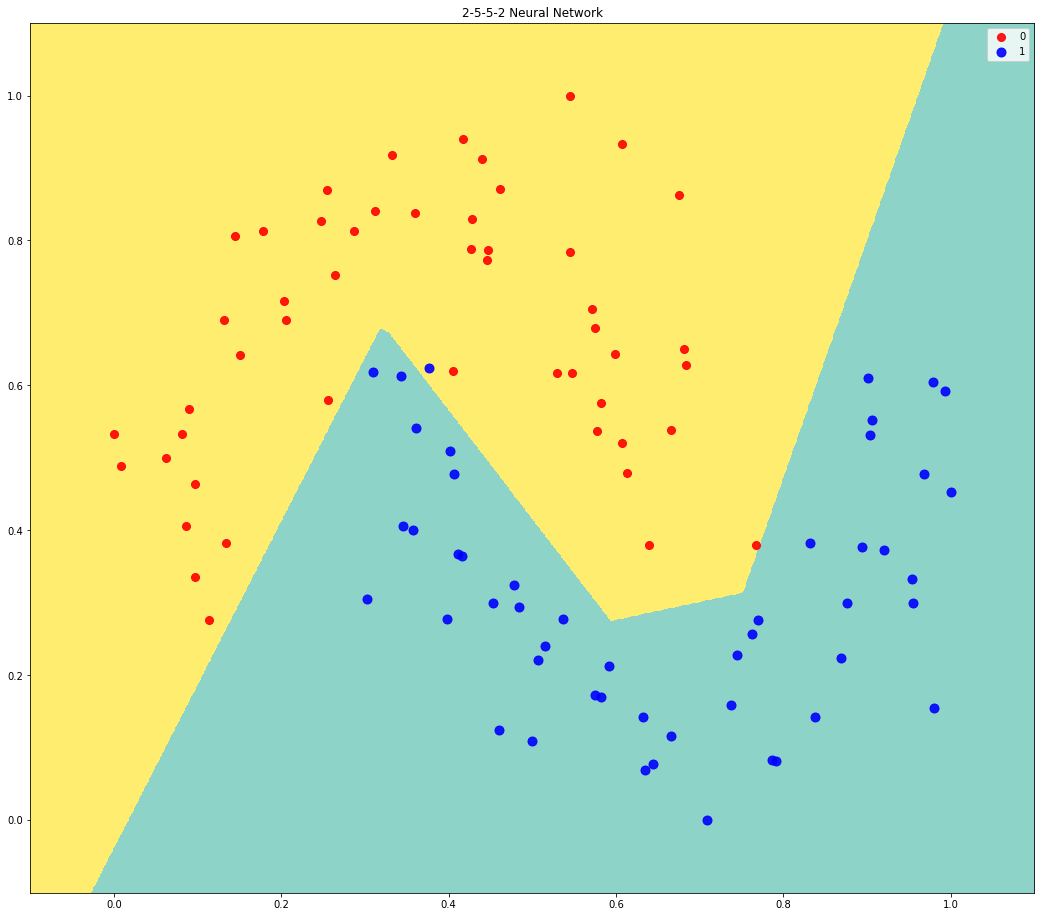

In [21]:
jnk=plot_2d_model(X, y, net, "2-{}-{}-2 Neural Network".format(net.N1,net.N2))

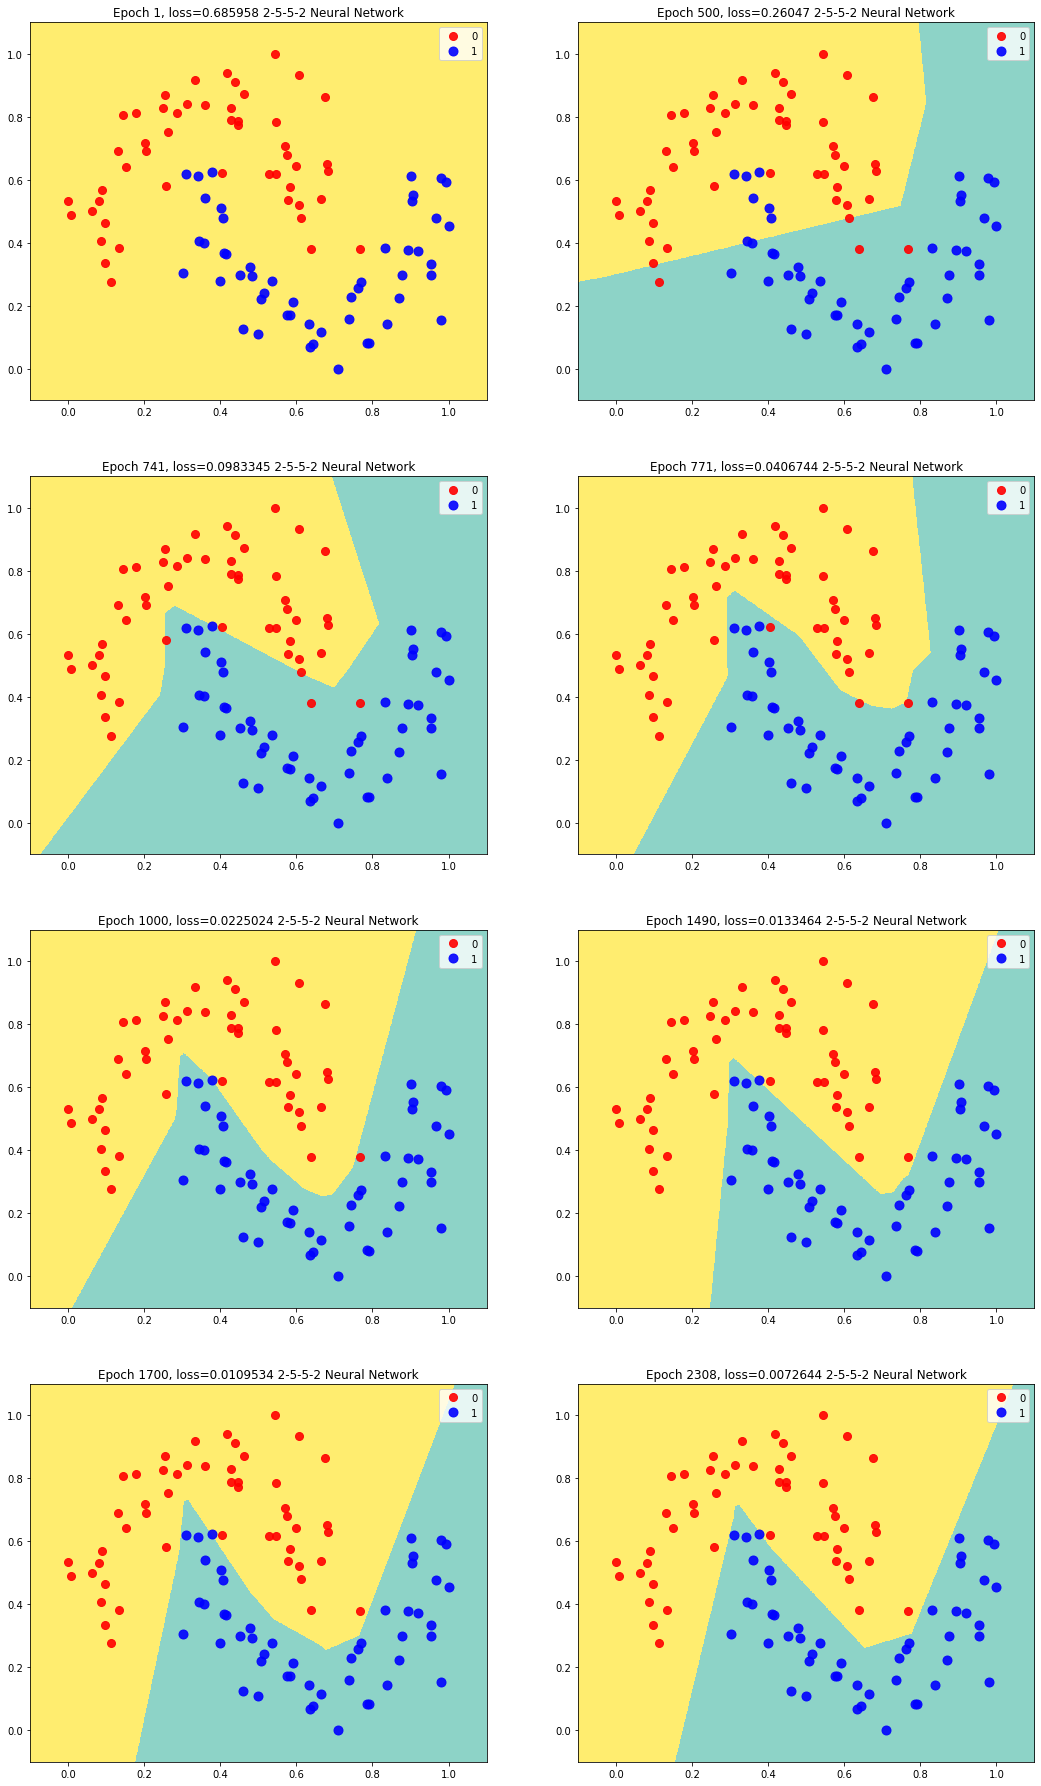

In [22]:
# Pick *best* model
best_epoch = np.argmin(losses)

ages = [ 1, 500, 741, 771, 1000, 1490, 1700, best_epoch]

fig = plt.figure(figsize=(18, 32))
spec = gridspec.GridSpec(ncols=2, nrows=4, width_ratios=[1,1], height_ratios=[2,2,2,2])

for i, age in enumerate(ages):
    age_state = models_states[age]
    net.load_state_dict(age_state)
    tit = "Epoch {}, loss={:g} 2-{}-{}-2 Neural Network".format(age, losses[age], net.N1,net.N2)
    ax = fig.add_subplot( spec[i] )
    subplot_2d_model(ax, X, y, net, subtitle=tit)
    

In [23]:
# Les poids
#net = Net(N1=5, N2=5, N3=5)
net.fc2.weight.data

tensor([[ 0.3180,  3.2797, -4.0026,  0.2224, -0.0795],
        [ 0.2377,  0.9096, -4.2760, -0.1656,  0.0336],
        [-0.3311,  2.0408, -6.2518,  0.1785,  0.1106],
        [ 5.8010,  3.0327,  0.3893,  0.1923,  0.3582],
        [-4.8161, -4.3553,  1.2838, -0.3966,  0.3961]])

In [24]:
# This is the output of the network at x=(0,0)
net(torch.tensor( (0,0), dtype=torch.float32 ))

tensor([ 29.7518, -57.9468], grad_fn=<AddBackward0>)

In [25]:
# Confusion matrix
# note that we need to convert the tensor back to a standard array:
y_pred = net(x_data).detach().numpy()

CM = confusion_matrix(y, y_pred)
print(CM)

[[50.  0.]
 [ 0. 50.]]


# Questions
Answer writing code and explanations.

- How many examples are missclassified ? 
- What is the error rate in percent ? -> **The error rate is 0% because there no samples misclassified**

- Try different learning rates and observe the convergence: is it sensitive to the rate value ?

In [26]:
y_hat_class = [np.argmax(y_pred[i]) for i in range(len(y_pred))]
y_diff = np.where(y_hat_class != y)[0]
num_sample_miss = len(y_diff)
print(f"The number of samples misclassified: {num_sample_miss}")

The number of samples misclassified: 0


### Different learning rate

In [27]:
def investigate_simple_nn(lr, epochs = 3000, hidden_size = (5,5), vis_res=False, early_stop = False):
    net = Net2(N1=hidden_size[0], N2= hidden_size[1])
    # The criteria to optimize (cost function)
    criterion = nn.CrossEntropyLoss()
    #optimizer = torch.optim.Adam(net.parameters(), 0.008)

    # Etonnants sauts !
    # optimizer = torch.optim.SGD(net.parameters(), lr=0.05, momentum=0.3)

    # Le meilleur trouvé:
    optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.1)
    
    # Learning (without mini-batch)
    
    min_nb_epochs = 100
    max_nb_epochs = epochs
    
    # Stop criteria: no average on window did not change more than min_change
    window_size=10
    min_change=1e-4

    losses = []
    models_states = OrderedDict()
#     for epoch in tqdm(range(max_nb_epochs)):
    for epoch in range(max_nb_epochs):
        for i in range(x_data.size(0)):
            x_i = x_data[ i:i + 1, :]
            y_i = y_data[ i:i + 1]
            # reset gradients to zero
            optimizer.zero_grad()
            # forward:
            outputs = net(x_i)
            loss = criterion(outputs, y_i)
            # backpropagation:
            loss.backward()
            optimizer.step()
        # After epoch, computes average loss on training set
        train_outputs = net(x_data)
        train_loss = criterion(train_outputs, y_data)
        losses.append(train_loss.data.item()) # record cost (loss) after each epoch
        models_states[len(losses)] = copy.deepcopy(net.state_dict())
#         if len(losses) % window_size == 1:
#             print("%04d\t%g" %(len(losses), losses[-1]) )

        if early_stop:
            if len(losses) > min_nb_epochs:
                last_avg_loss = np.mean(losses[-window_size:])
                before_avg_loss = np.mean(losses[-2*window_size:-window_size])
                if abs(last_avg_loss-before_avg_loss) < min_change:
#                     print("no more changes: stopping !")
                    break
    if vis_res:
        plt.plot(losses, label="loss")
        plt.legend()
        print(losses[-1])
    return losses, models_states

0.8305243849754333


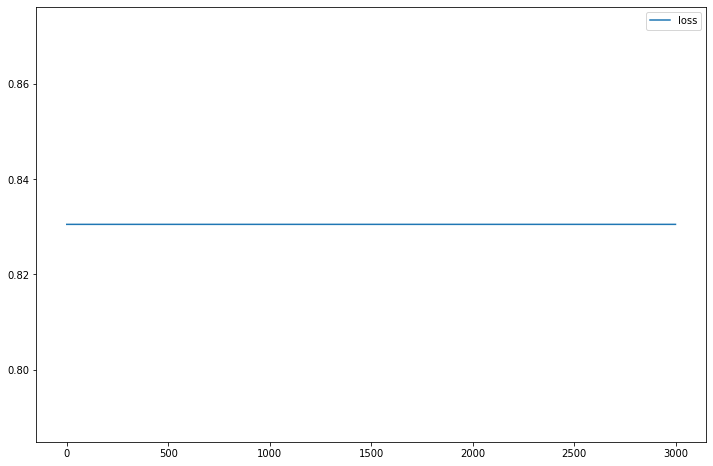

In [28]:
loss, model = investigate_simple_nn(lr = 1., vis_res=True, early_stop = False)

**As the above figure showed that the model can't update the parameter with the high-value learning rate, then the losses haven't fallen.**

0.8305243849754333


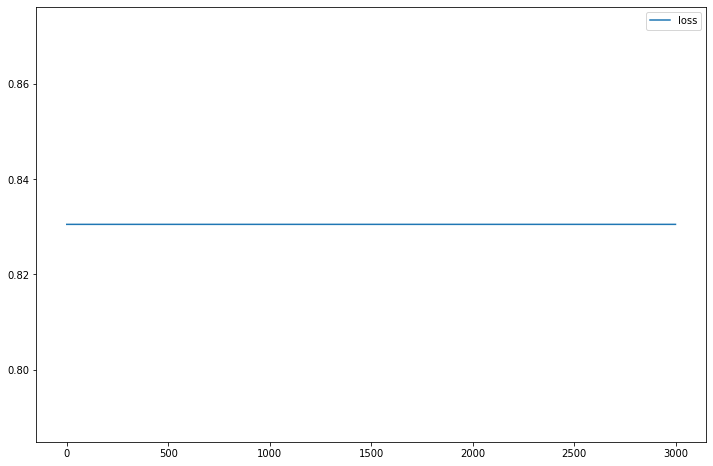

In [29]:
loss, model = investigate_simple_nn(lr = 1., vis_res=True, early_stop = False)

-> **As the above figure showed that the model hasn't fitted learned with current parameters with the low-value learning rate yet, then the losses have a high sloped. In other words, the model hasn't converged yet.**

- Try to enhance the neural network model: change `N1`, `N2`: for each values, record the value of the cost, the number of errors and the error rate. What is your optimal architecture ?

**Answer**: I try discovering with 25 pairs `N1` and `N2`, and the best model achieves with the `N1` = 5 and `N2` = 3

In [30]:
from fastprogress.fastprogress import master_bar, progress_bar

mb = master_bar(range(1,10,2))
models = []
losses = []
last_losses = []
ite = 0
list_arch = []
mb.names = ['loss']
for h1 in mb:
    for h2 in progress_bar(range(1,10,2), parent=mb):
        loss, model = investigate_simple_nn(lr = 1e-2, epochs = 3000, hidden_size = (h1,h2), vis_res=False, early_stop = True)
        models.append(model)
        losses.append(loss)
        last_losses.append(loss[-1])
        ite += 1
        list_arch.append([h1,h2])

In [37]:
list_arch[np.argmin(np.array(last_losses))]

[5, 3]